## Advanced Lane Detection

## Goals and Objectives

The goals / steps of this project are the following:

-  Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
-  Apply a distortion correction to raw images.
-  Use color transforms, gradients, etc., to create a thresholded binary image.
-  Apply a perspective transform to rectify binary image ("birds-eye view").
-  Detect lane pixels and fit to find the lane boundary.
-  Determine the curvature of the lane and vehicle position with respect to center.
-  Warp the detected lane boundaries back onto the original image.
-  Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import glob
import pickle
import math
%matplotlib inline

## Camera Calibration

In [2]:
def calibrate(path, out_dir):
    images = glob.glob(path)
    obj_points=[]
    img_points=[]
    for filename in images:
        for ny in [5,6]:
            for nx in [6,7,8,9]:
                img = cv2.imread(filename)
                # Convert to gray
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                # Find the chessboard corners
                ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
                obj_point = np.zeros((nx*ny, 3), np.float32)
                # Transform this to 2x2 array
                obj_point[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
                # If successful in finding cornere
                if ret:
                    obj_points.append(obj_point)
                    img_points.append(corners)
                    chess_board_corners= cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
                    image_name = os.path.split(filename)[1]
                    out_image_name = out_dir + 'nx_' +str(nx) +'ny_' + str(ny) + '_' + image_name
                    cv2.imwrite(out_image_name, img)
                    break
        cv2.destroyAllWindows()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)
    return mtx, dist

out_dir = 'output_images/corners_found/'
path = os.path.join("camera_cal", "*.jpg")
mtx, dist = calibrate(path, out_dir)
# Save the points for use later
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_dist_pickle.p", "wb" ) )

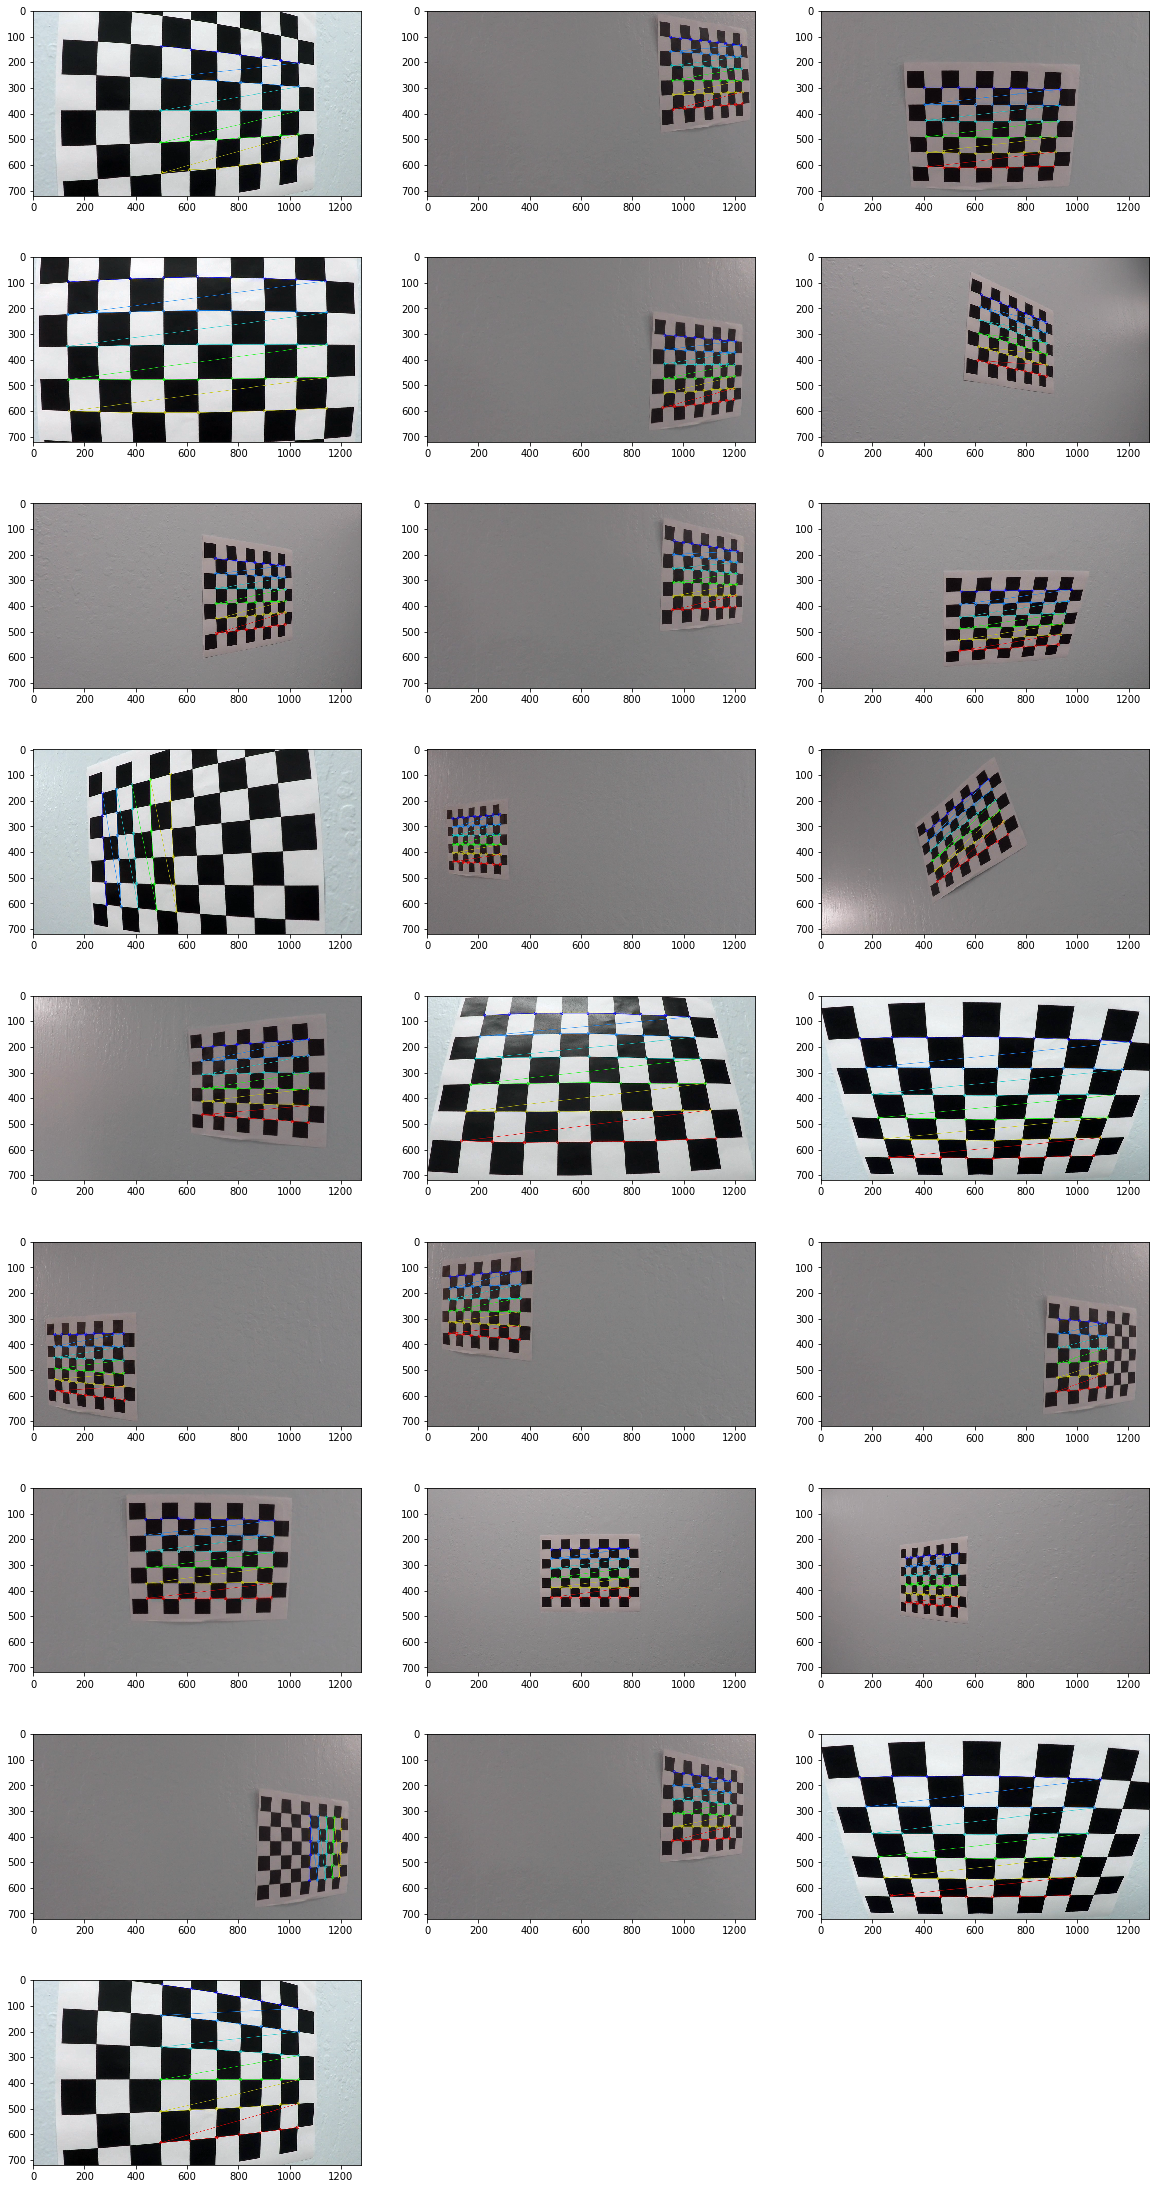

In [7]:
path = os.path.join('output_images/corners_found/', "*.jpg")
images = glob.glob(path)
t_images = len(images)
plt.figure(figsize=(20,40))
idx = 1
for fname in images:
    img = cv2.imread(fname)
    plt.subplot(math.ceil(t_images/3), 3, idx)
    plt.imshow(img)
    idx+=1

([], <a list of 0 Text yticklabel objects>)

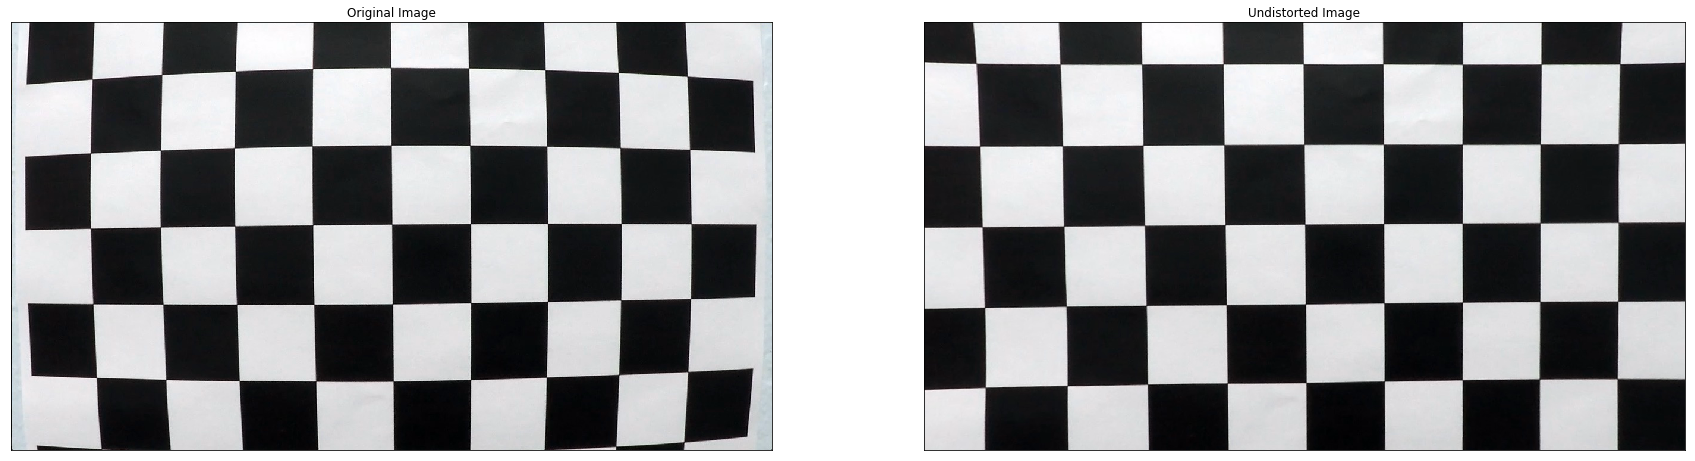

In [8]:
import pickle
def undistort(img, mtx, dist):
    # Undistort
    return cv2.undistort(img, mtx, dist, None, mtx)

# Read the values from pickle
with open('camera_dist_pickle.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
test_image_path = os.path.join('camera_cal', 'calibration1.jpg')
test_image = cv2.imread(test_image_path)
undistorted_img = undistort(test_image, mtx, dist)


plt.figure(figsize=(30,40))
plt.subplot(121)
plt.imshow(test_image)
plt.title('Original Image')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(undistorted_img)
plt.title('Undistorted Image')
plt.xticks([])
plt.yticks([])

## Apply distortion to raw images

([], <a list of 0 Text yticklabel objects>)

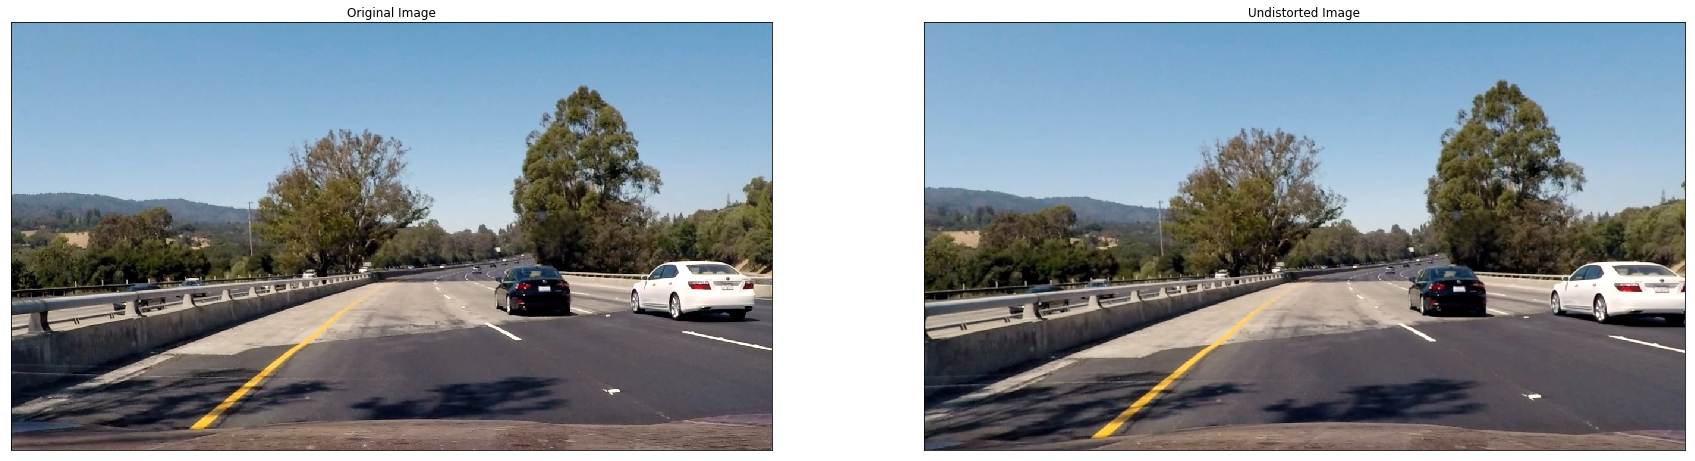

In [9]:
test_image = plt.imread('test_images/test4.jpg')
undistorted_img = undistort(test_image, mtx, dist)


plt.figure(figsize=(30,40))
plt.subplot(121)
plt.imshow(test_image)
plt.title('Original Image')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(undistorted_img)
plt.title('Undistorted Image')
plt.xticks([])
plt.yticks([])

## Create a threshold binary image

(720, 1280, 3)
(720, 1280)


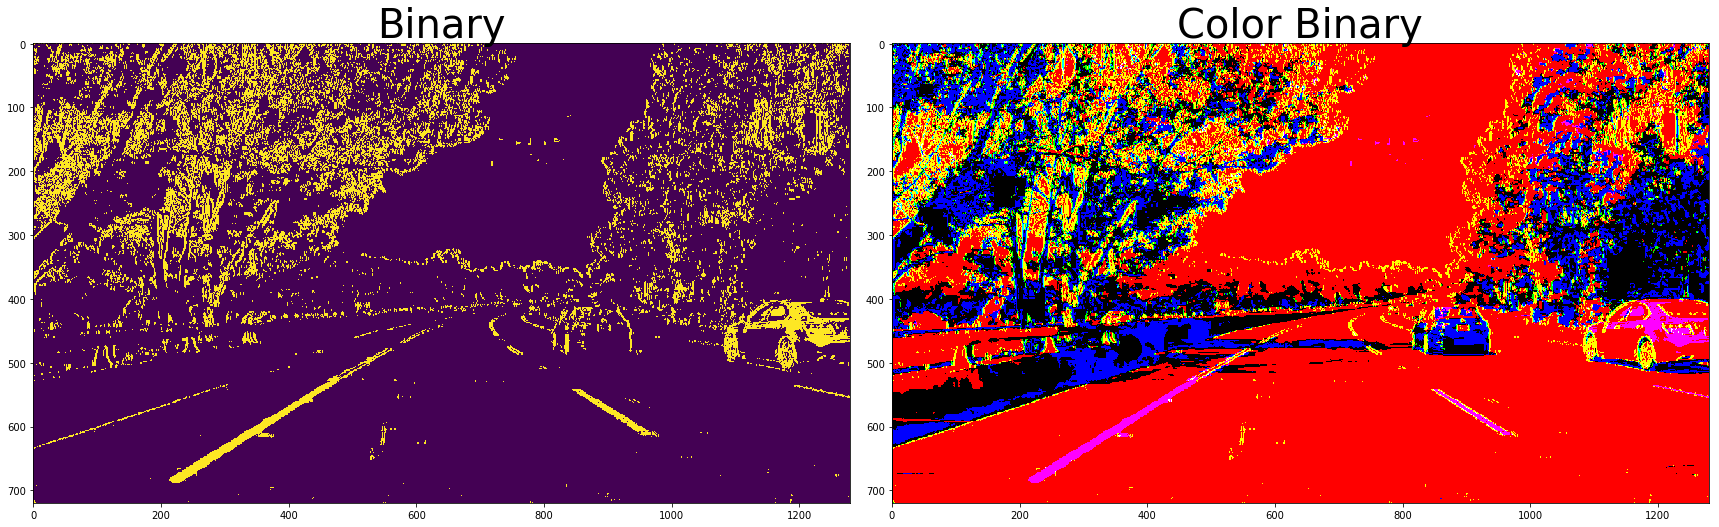

In [29]:
def threshold_binarize(img, s_thresh=(120, 255), sx_thresh=(20, 255),l_thresh=(40,255)):
    img = np.copy(img)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
     # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    # Threshold saturation
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Thershold Light
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    # color channels
    color_binary = np.dstack(( l_binary, sxbinary, s_binary)).astype('uint8') * 255
    binary = np.zeros_like(sxbinary)
    binary[((l_binary == 1) & (s_binary == 1) | (sxbinary==1))] = 1
    #binary = 255*np.dstack((binary,binary,binary)).astype('uint8')    
    return binary, color_binary


img = plt.imread('test_images/test5.jpg')

shape = img.shape
print(shape)
binary,color_binary = threshold_binarize(img)
# plt.imsave(out_dir+'binary.jpg',binary)
# plt.imsave(out_dir+'color_binary.jpg',color_binary)

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
print(binary.shape)
ax1.imshow(binary)
ax1.set_title('Binary', fontsize=40)

ax2.imshow(color_binary)
ax2.set_title('Color Binary', fontsize=40)



## Perspective Transform

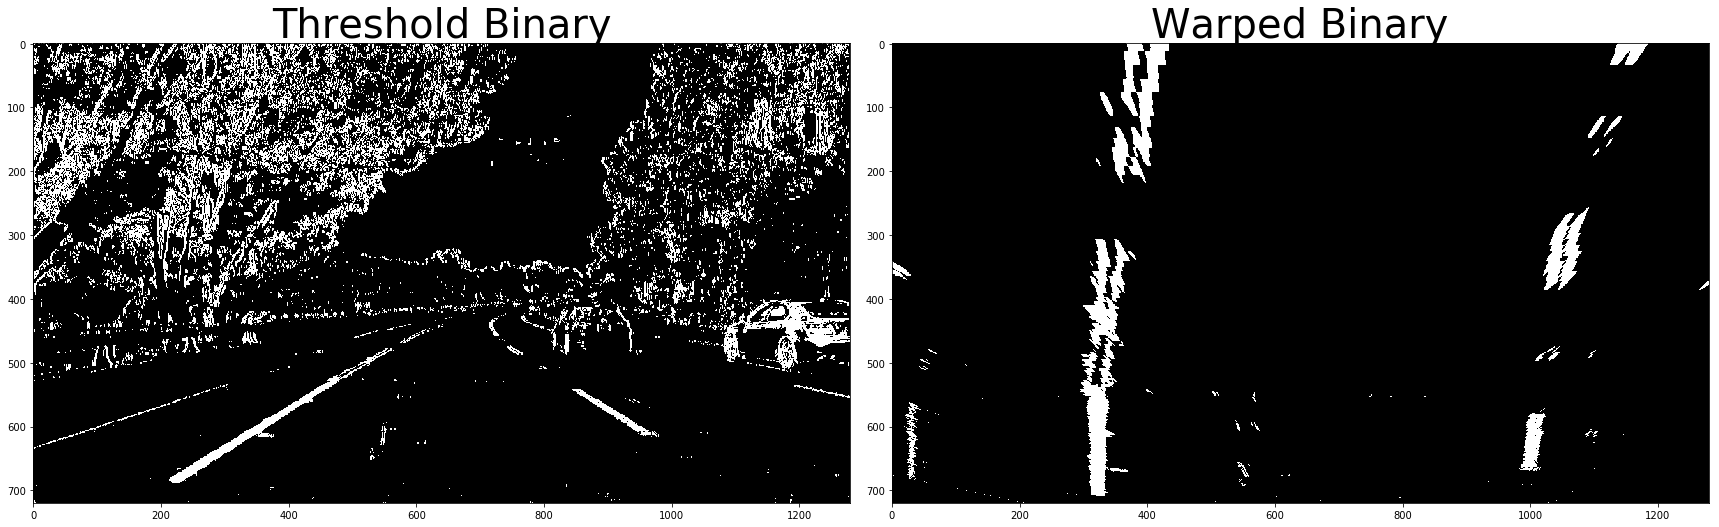

In [30]:
def warp(img, bird_view= True):
    corners = np.float32([[190,720],[589,457],[698,457],[1145,720]])
    new_top_left=np.array([corners[0,0],0])
    new_top_right=np.array([corners[3,0],0])
    offset=[150,0]
    
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([corners[0],corners[1],corners[2],corners[3]])
    dst = np.float32([corners[0]+offset,new_top_left+offset,new_top_right-offset ,corners[3]-offset])    
    if bird_view:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)    
    return warped, M

img = plt.imread('test_images/test5.jpg')

binary,color_binary = threshold_binarize(img)
binary_warped,_ = warp(binary)

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(binary, cmap='gray')
ax1.set_title('Threshold Binary', fontsize=40)

ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Warped Binary', fontsize=40)


## Fit Lane Boundary

In [54]:
def process_firstframe(binary_warped):
    # Take a histogram of the bottom half of the image
    # Sum all the values from middle to bottom. y -axis
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    # argmax returns the position of the max value from start (0 each time) 
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit

def process_nextframes(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit


def pipeline(img):
    global line
    # Undistort the image
    # Read the values from pickle
    with open('camera_dist_pickle.p', mode='rb') as f:
        dist_pickle = pickle.load(f)
        mtx = dist_pickle["mtx"]
        dist = dist_pickle["dist"]
    undistorted = undistort(img, mtx, dist)
    # Color and gradient binary
    threshold_binary,_ = threshold_binarize(undistorted)
    # perspective transform
    binary_warped, M = warp(threshold_binary)
    if line.first_frame_processed:
        left_fit, right_fit = process_nextframes(binary_warped, line.left_fit, line.right_fit)
    else:
        left_fit, right_fit = process_firstframe(binary_warped)
    line.update_fits(left_fit, right_fit)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp,MinV = warp(color_warp, bird_view= False)
    newwarp = cv2.warpPerspective(color_warp, MinV, (img.shape[1], img.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    ## Add Radius of Curvature
    cv2.putText(result,'Radius of Curvature: %.2fm' % line.curvature,(20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    
    ## Add distance from center
    position_from_center = line.get_position_from_center()
    if position_from_center < 0:
        text = 'left'
    else:
        text = 'right'
    cv2.putText(result,'Distance From Center: %.2fm %s' % (np.absolute(position_from_center), text),(20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)

    return result


In [33]:
class Line:
    def __init__(self):
        # if the first frame of video has been processed
        self.first_frame_processed = False  
        
        self.img = None
        
        self.mse_tolerance = 0.01
        self.left_fit = [np.array([False])] 
        self.right_fit = [np.array([False])] 
        
        self.y_eval = 700
        self.midx = 640
        self.ym_per_pix = 3.0/72.0 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/660.0 # meters per pixel in x dimension
        self.curvature = 0
       
       
    def update_fits(self, left_fit, right_fit):
        """Update the co-efficients of fitting polynomial
        """
        if self.first_frame_processed:
            left_error = ((self.left_fit[0] - left_fit[0]) ** 2).mean(axis=None)      
            right_error = ((self.right_fit[0] - right_fit[0]) ** 2).mean(axis=None)        
            if left_error < self.mse_tolerance:
                self.left_fit = 0.75 * self.left_fit + 0.25 * left_fit   
            if right_error < self.mse_tolerance:
                self.right_fit = 0.75 * self.right_fit + 0.25 * right_fit
        else:
            self.right_fit = right_fit
            self.left_fit = left_fit
        
        self.update_curvature(self.right_fit)
     
     
    def update_curvature(self, fit):
        """Update radius of curvature
        """
        y1 = (2*fit[0]*self.y_eval + fit[1])*self.xm_per_pix/self.ym_per_pix
        y2 = 2*fit[0]*self.xm_per_pix/(self.ym_per_pix**2)
        curvature = ((1 + y1*y1)**(1.5))/np.absolute(y2)
        
        if self.first_frame_processed:
            self.curvature = curvature
        
        elif np.absolute(self.curvature - curvature) < 500:
            self.curvature = 0.75*self.curvature + 0.25*(((1 + y1*y1)**(1.5))/np.absolute(y2)) 
            
    def get_position_from_center(self):
        x_left_pix = self.left_fit[0]*(self.y_eval**2) + self.left_fit[1]*self.y_eval + self.left_fit[2]
        x_right_pix = self.right_fit[0]*(self.y_eval**2) + self.right_fit[1]*self.y_eval + self.right_fit[2]
        
        return ((x_left_pix + x_right_pix)/2.0 - self.midx) * self.xm_per_pix

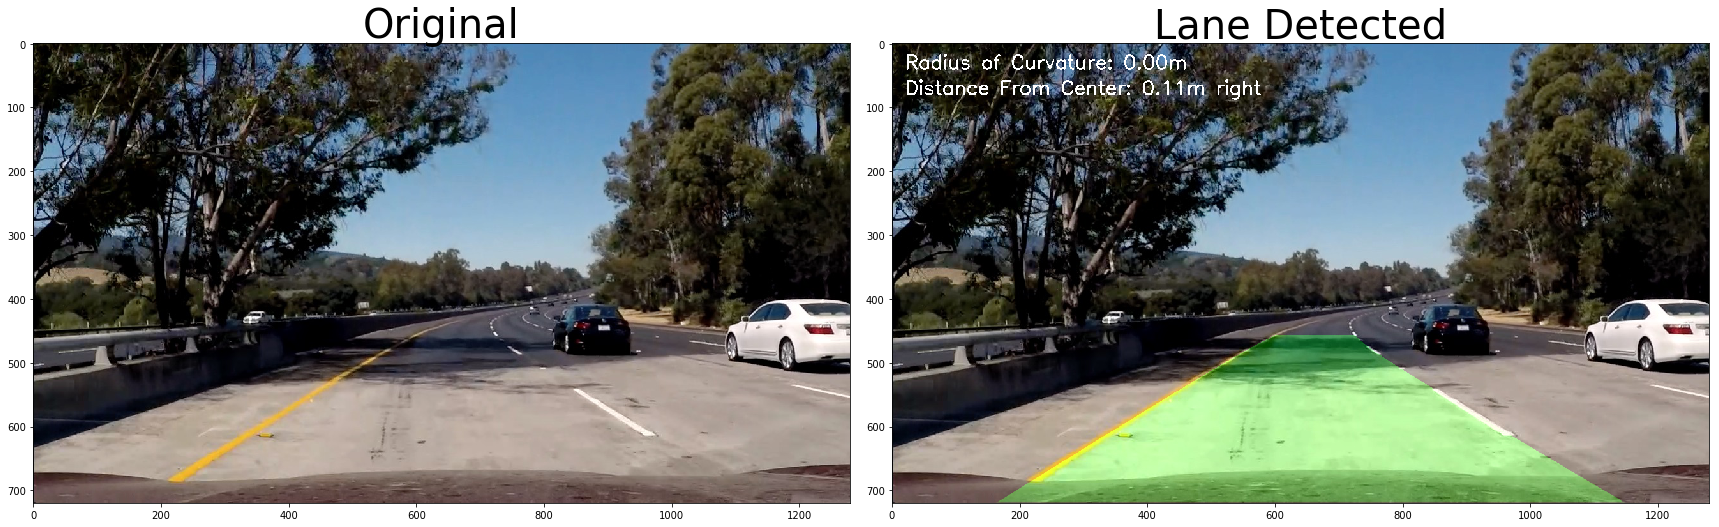

In [55]:
test_image = plt.imread('test_images/test5.jpg')
line=Line()
result = pipeline(test_image)
# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(test_image)
ax1.set_title('Original', fontsize=40)

ax2.imshow(result)
ax2.set_title('Lane Detected', fontsize=40)

In [57]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

line=Line()

white_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [03:01<00:00,  6.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 45s, sys: 52.7 s, total: 4min 38s
Wall time: 3min 2s
